In [1]:
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
from pathlib import Path
import seaborn as sns
import os

In [3]:
folders = glob.glob('results/*')
folders

['results/2025-02-28']

In [4]:
levels = glob.glob(f'{folders[0]}/*')
levels

['results/2025-02-28/lic3',
 'results/2025-02-28/lic0',
 'results/2025-02-28/lic2',
 'results/2025-02-28/lic1']

In [5]:
def read_from_lic(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/*'):
        num_cores = int(Path(file).stem) + 1
        read_df = pd.read_csv(file)
        read_df['core_count'] = num_cores

        df = pd.concat([df, read_df])

    return df

In [6]:
freq_vs_number_of_cores = pd.DataFrame()

for level in levels:
    lic_data = read_from_lic(level)
    lic_data['level'] = os.path.basename(level)
    freq_vs_number_of_cores = pd.concat([freq_vs_number_of_cores, lic_data])

In [7]:
license_level_to_name = {
    'lic0': 'SSE',
    'lic1': 'AVX2',
    'lic2': 'AVX512',
    'lic3': 'AMX'
}

LIC_NAME = 'License name'
CORE_COUNT = 'Number of active cores'
MAX_TURBO_FREQ = 'Maximum opportunistic turbo frequency [MHz]'

freq_vs_number_of_cores[LIC_NAME] = freq_vs_number_of_cores['level'].apply(lambda v: license_level_to_name[v])
freq_vs_number_of_cores[CORE_COUNT] = freq_vs_number_of_cores['core_count']

# Filter out every row that does not have the perf-freq metric and relabel average to per-freq
freq_vs_number_of_cores = freq_vs_number_of_cores.loc[freq_vs_number_of_cores['metric'] == 'perf-freq']
freq_vs_number_of_cores[MAX_TURBO_FREQ] = freq_vs_number_of_cores['average'] * freq_vs_number_of_cores['core_count'] * 1000

freq_vs_number_of_cores
        

,metric,num_timepoints,duration_ms,average,stddev,core_count,level,License name,Number of active cores,Maximum opportunistic turbo frequency [MHz]
1,perf-freq,136,13512,3.292380,0.004472,1,lic3,AMX,1,3292.3800
1,perf-freq,166,16514,0.039855,0.000051,55,lic3,AMX,55,2192.0030
1,perf-freq,167,16611,0.039126,0.000066,56,lic3,AMX,56,2191.0392
1,perf-freq,147,14612,0.121671,0.000587,27,lic3,AMX,27,3285.1170
1,perf-freq,139,13811,0.299289,0.000324,11,lic3,AMX,11,3292.1790
...,...,...,...,...,...,...,...,...,...,...
1,perf-freq,133,13212,0.068673,0.000253,44,lic1,AVX2,44,3021.6340
1,perf-freq,132,13112,0.109023,0.000128,32,lic1,AVX2,32,3488.7360
1,perf-freq,132,13111,0.093946,0.000098,35,lic1,AVX2,35,3288.0995
1,perf-freq,133,13212,0.060894,0.000122,49,lic1,AVX2,49,2983.8109


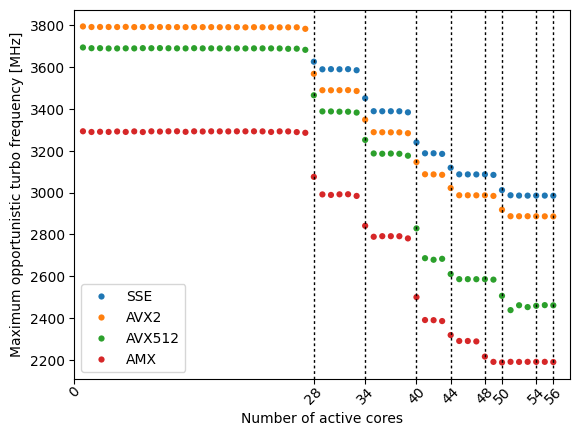

In [8]:
# plt.figure(figsize=(10,6))
colors = [sns.color_palette()[3], sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[1]]

ax = sns.scatterplot(data=freq_vs_number_of_cores, x=CORE_COUNT, y=MAX_TURBO_FREQ, hue=LIC_NAME, linewidth=1.5, marker='o', palette=colors)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,3,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


# Overlay the blue markers for the SSE2 license on the left
# sse_marker = freq_vs_number_of_cores[freq_vs_number_of_cores[LIC_NAME] == 'SSE']
# plt.plot(sse_marker[CORE_COUNT], sse_marker[MAX_TURBO_FREQ], color=sns.color_palette()[0], linestyle='None', markeredgewidth=0.0, ms=4.5, marker=matplotlib.markers.MarkerStyle("o", fillstyle="left"))

buckets = [28,34,40,44,48,50,54,56]

for i in buckets:
    plt.axvline(x=i, color='black', dashes=[2], linewidth=1)

# ax.set_ylim(0, 4000)
ax.set_xlim(0, 58)
ax.set_xticks([0] + buckets)

plt.xticks(rotation=45)
ax.tick_params(axis='x', pad=0)

plt.savefig('../../thesis/fig/validate-avx-frequency-license-bands.pdf', bbox_inches='tight')